## Project Goals
The goal of this project is to identify drivers of churn for the benefit of creating a solution to reduce the rate of churn among customers. 

## Project Description
With an unsteady and increasingly competitive market, it is cheaper to retain current customers than to establish new ones. We will observe various details of customer contracts and discover what may be driving them to churn and will use the information to create a model to predict future customer churn and a recommendation in reducing rate of churn.



## Initial Questions

1. Are customers with fiber more or less likely to churn?
2. Do customers who churn have a higher average monthly spend than those who don't?
3. Are customers with dependents less likely to churn than those who don't?
4. Are seniors less likely to churn?

## Data Dictionary

| variable      | meaning       |
| ------------- |:-------------:|
|RF|Random Forest modeling algorithm|
|KNN|K-Nearest Neighbors modeling algorithm |
|Logit |Logistic Regression modeling algorithm|
|df|Dataframe of raw telco data from sql server|
|train| training dataset, a major cut from the df|
|validate| validate dataset, used to prevent overfitting|
|test| test dataset, to test the top model on unseen data|
|chi2 | statistical test used to compare churn with various categories|

## Wrangle Telco Data
To acquire the telco data used, I ran a query on the telco_churn database from the mySQL server. I selected all the columns from the customers table and joined the internet service, contract, and payment types.

In [1]:
# Import module with function to acquire data from SQL server's telco_churn database
import acquire

# execute the function and store it in a dataframe
df = acquire.get_telco_data()

Cleaning the data was executed in the following steps:
- Drop duplicates
- Transformed total_charges into a float
- Create dummy variables for categorical columns (gender, dependents, etc.)
- Drop unnecessary columns (due to dummy vars)

In [2]:
import prepare
import pandas as pd

df = prepare.prep_telco(df)

We then split our data so we can evaluate models without spoiling new data.
- Train: Used to build models
- Validate: Verify the fit of the model, ensure the model is not overfit
- Test: Estimate how well the model performs on never-before-seen data

In [3]:
train, validate, test = prepare.split_telco(df)

## Our Data Landscape


- Of 7032 records, 1869 (26.6%) customers have churned. 
- The average monthly charges for all users is $64.80. 
- 3096 Users utilize fiber services.
- 2099 Users have dependents
- 1142 Users are senior citizens


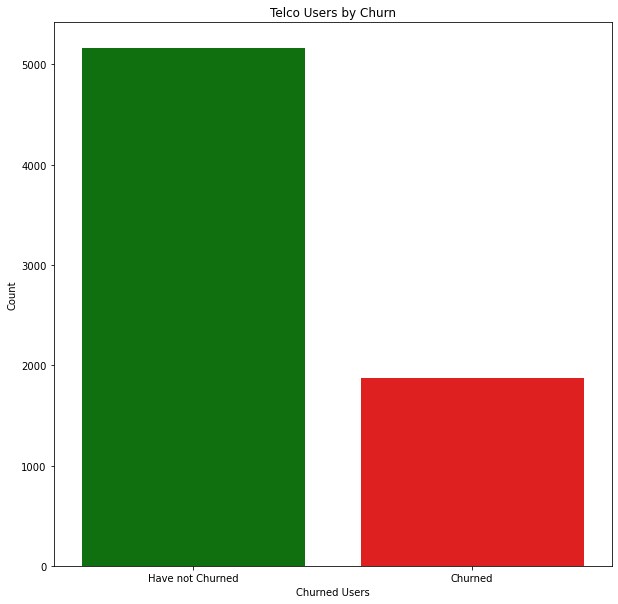

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

df_churn = pd.DataFrame(df.churn.value_counts()).reset_index()
plt.figure(figsize = (10,10))
sns.barplot(data = df_churn,x = 'index', y = 'churn', palette=('green','red'))
plt.title('Telco Users by Churn')
plt.xlabel('Churned Users')
plt.ylabel('Count')
plt.xticks([0,1], ['Have not Churned','Churned']);

## Exploratory analysis: Who is likely to churn?

### 1. Are customers with fiber more or less likely to churn?

- Run a chi-square test for internet service type ID and churn

In [5]:
from scipy import stats
alpha = 0.5

observe = pd.crosstab(train.churn, train.internet_service_type_id)
chi2, p, degf, expected = stats.chi2_contingency(observe)
print('Observed\n')
print(observe.values)
print('------------------\nExpected\n')
print(expected.astype(int))
print('------------------\n')
print(f'chi^2 = {chi2:.2f}')
print(f'p     = {p:.2f}')

Observed

[[1102  982  807]
 [ 266  716   64]]
------------------
Expected

[[1004 1246  639]
 [ 363  451  231]]
------------------

chi^2 = 412.29
p     = 0.00


#### Users with Fiber are more likely to churn

### 2. Do customers who churn have a higher average monthly spend than those who have not churned?

- Group dataframe by churn then average the monthly charges
- Run a chi-square test for monthly charges and churn

In [6]:
train.groupby(train.churn).monthly_charges.mean()

churn
0    60.764182
1    73.662428
Name: monthly_charges, dtype: float64

In [7]:
observe = pd.crosstab(train.churn, train.monthly_charges)
chi2, p, degf, expected = stats.chi2_contingency(observe)
print('Observed\n')
print(observe.values)
print('------------------\nExpected\n')
print(expected.astype(int))
print('------------------\n')
print(f'chi^2 = {chi2:.2f}')
print(f'p     = {p:.2f}')

Observed

[[1 1 4 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
------------------
Expected

[[0 0 2 ... 0 0 0]
 [0 0 1 ... 0 0 0]]
------------------

chi^2 = 1656.61
p     = 0.00


#### Users who churn have a higher monthly average spend than those who have not churned.

### 3. Are customers with dependents less likely to churn than those who don't?
- Run a chi-square test for dependents and churn

In [8]:
observe = pd.crosstab(train.churn, train.dependents_Yes)
chi2, p, degf, expected = stats.chi2_contingency(observe)
print('Observed\n')
print(observe.values)
print('------------------\nExpected\n')
print(expected.astype(int))
print('------------------\n')
print(f'chi^2 = {chi2:.2f}')
print(f'p     = {p:.2f}')

Observed

[[1898  993]
 [ 866  180]]
------------------
Expected

[[2029  861]
 [ 734  311]]
------------------

chi^2 = 107.05
p     = 0.00


#### Users who have dependents are less likely to churn.

### 4. Are seniors less likely to churn?
- Run a chi-square test for senior citizen and churn

In [9]:
observe = pd.crosstab(train.churn, train.senior_citizen)
chi2, p, degf, expected = stats.chi2_contingency(observe)
print('Observed\n')
print(observe.values)
print('------------------\nExpected\n')
print(expected.astype(int))
print('------------------\n')
print(f'chi^2 = {chi2:.2f}')
print(f'p     = {p:.2f}')

Observed

[[2524  367]
 [ 766  280]]
------------------
Expected

[[2415  475]
 [ 874  171]]
------------------

chi^2 = 109.76
p     = 0.00


#### Senior citizens are less likely to churn

### Summary: Who IS most likely to churn?

Users who churn the most are users with higher monthly charges and users with fiber internet services.

## Predicting Churn
We are using classification machine learning algorithms to answer this boolean value question. The models will be fit on a training dataset and then validated with a separate dataset to ensure there is no overfitting. We will focus on recall, with the model aiming for best identifiers for churn.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

### Baseline
A baseline is evaluated with the assumption nobody churns and we will examine the accuracy of that.

In [11]:
# establish baseline
train['baseline'] = train.churn.value_counts().idxmax()

In [12]:
# examine the baseline predictions vs. the churned in our training dataset
pd.crosstab(train.churn, train.baseline)

baseline,0
churn,
0,2891
1,1046


In [13]:
# evaluate accuracy of baseline predictions made on training dataset
accuracy_score(train.churn, train.baseline)

0.7343154686309372

In [14]:
train.drop(columns = 'baseline', inplace = True)

## Three Models
The best performing models were K-Nearest Neighbors, Random Forest, and Logistic Regression. The K-Nearest Neighbors  performed the best on our train dataset at 79% accuracy and 96% recall. The random forest that predicted based on the specified features was overfit, so the model was tested over the entire dataset. This applies to the Logistic Regression model as well. The KNN performed best with the features included and was not overfit.

In [15]:
# Create X and y train columns for train, validate, test sets where y is target and x is predictors
X_train = train.drop(columns=['churn'])
y_train = train.churn

X_validate = validate.drop(columns=['churn'])
y_validate = validate.churn

X_test = test.drop(columns=['churn'])
y_test = test.churn

# Establish target features
features = ['monthly_charges', 'internet_service_type_id', 'senior_citizen', 'dependents_Yes']

### Logistic Regression

#### Evaluate on Train

In [16]:
# Create the logistic regression model
logit = LogisticRegression(random_state = 123)
# Fit the model to predictors and target
logit = logit.fit(X_train, y_train)
# Predict outcomes
y_pred = logit.predict(X_train)
# Predicted estimates
y_pred_probability = logit.predict_proba(X_train)

# Print scoring
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      2891
           1       0.65      0.54      0.59      1046

    accuracy                           0.80      3937
   macro avg       0.75      0.72      0.73      3937
weighted avg       0.79      0.80      0.79      3937



#### Evaluate on Validate

In [17]:
# Predict on validate
y_pred = logit.predict(X_validate)

# evaluate on validate
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1239
           1       0.63      0.55      0.59       449

    accuracy                           0.79      1688
   macro avg       0.73      0.72      0.72      1688
weighted avg       0.79      0.79      0.79      1688



### KNN

#### Evaluate on Train

In [18]:
# Create knn model
knn = KNeighborsClassifier(n_neighbors = 8, weights = 'uniform')
# Fit model to predictors and target
knn = knn.fit(X_train[features], y_train)
# Predict outcomes
y_pred = knn.predict(X_train[features])
# Probability estimates
y_pred_proba = knn.predict_proba(X_train[features])

# Print scoring
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.95      0.86      2891
           1       0.68      0.32      0.44      1046

    accuracy                           0.78      3937
   macro avg       0.74      0.63      0.65      3937
weighted avg       0.76      0.78      0.75      3937



#### Evaluate on Validate

In [19]:
# predict on validate
y_pred = knn.predict(X_validate[features])

# evaluate on validate
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.90      0.83      1239
           1       0.47      0.24      0.31       449

    accuracy                           0.73      1688
   macro avg       0.62      0.57      0.57      1688
weighted avg       0.69      0.73      0.69      1688



### Random Forest

#### Evaluate on Train

In [26]:
# features fed to model
# Create random forest model
rf = RandomForestClassifier(max_depth = 3, random_state=123)
# Fit the model to train
rf = rf.fit(X_train, y_train)
# Predict outcomes
y_pred = rf.predict(X_train)
# Predicted class probabilities of the trees in the forest
y_proba = rf.predict_proba(X_train)

# Print out scoring
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.96      0.87      2891
           1       0.76      0.32      0.45      1046

    accuracy                           0.79      3937
   macro avg       0.78      0.64      0.66      3937
weighted avg       0.79      0.79      0.76      3937



#### Evaluate on Validate

In [27]:
# predict on validate
y_pred = rf.predict(X_validate)

# evaluate on validate
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.95      0.86      1239
           1       0.70      0.32      0.44       449

    accuracy                           0.78      1688
   macro avg       0.75      0.63      0.65      1688
weighted avg       0.77      0.78      0.75      1688



#### Evaluate on Test

In [34]:
# predict on test
y_pred = rf.predict(X_test)

# probability estimates
y_proba = rf.predict_proba(X_test)

# evaulate on validate
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.96      0.87      1033
           1       0.75      0.30      0.43       374

    accuracy                           0.79      1407
   macro avg       0.77      0.63      0.65      1407
weighted avg       0.78      0.79      0.75      1407



I expect the RF model to perform at about 79% accuracy with a 96% recall score, ensuring emphasis on predicting those who have churned correctly.

## Conclusion
### Summary
#### What is driving churn?
Through statistical analysis, we've found that the primary drivers for churn are higher monthly charges and most users who churn have fiber internet services. Though not necessarily primary drivers, there is a lower chance to churn if the customer is a senior citizen or has dependents.

#### Modeling
The data was modeled through three different classifaction algorithms, with Random Forest being the top performer. This model was chosen due to having the highest recall score during training, while the accuracy was only about 1% behind the highest accuracy model. The model performed as well as it had in training, at 79% accuracy and 96% recall scores. These measures are what I am using to estimate accuracy in the future.

### Recommendations
Since the primary drivers of churn have been identified, my recommendation is to provide discounts to fiber internet services packages.

### Next Steps
To improve modeling, refining the algorithms to reduce overfitting while the specified drivers of churn are chosen for the model to train on will be beneficial in focusing the model on the primary drivers of churn. 
Continuing with the model training on a broad dataset, features to collect in the future that may be helpful would be data limits, data usage, and any extra charges for exceeding the data cap.